In [159]:
import numpy as np

class AntColony(object):
    def __init__(self, distances_array, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        創建螞蟻群類
        :param distances_array: 二維陣列，表示各點之間的距離
        :param n_ants: 螞蟻的數量
        :param n_best: 每代中選擇的最佳路徑數量
        :param n_iterations: 迭代的次數
        :param decay: 蒸發率
        :param alpha: 訊息素的重要程度
        :param beta: 可見度的重要程度
        """
        self.distances  = distances_array
        self.pheromone = np.ones(self.distances.shape) / len(distances_array)
        self.all_indexes = range(len(distances_array))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        """ 執行螞蟻群算法 """
        shortest_path_found = None
        all_time_shortest_path = ("placeholder", np.inf)
        cost_list = []  # List to store the cost of shortest path of each iteration
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheromone(all_paths, self.n_best, shortest_path_found=shortest_path_found)
            shortest_path_found = min(all_paths, key=lambda x: x[1])
            cost_list.append(shortest_path_found[1])  # Append the cost of the current shortest path
            if shortest_path_found[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path_found
            self.pheromone = self.pheromone * self.decay  # Apply decay to pheromone
        return all_time_shortest_path, cost_list


    def spread_pheromone(self, all_paths, n_best, shortest_path_found):
        """ 傳播訊息素 """
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]
        # Extra pheromone for the current iteration's shortest path
        if shortest_path_found is not None:
            for move in shortest_path_found[0]:
                self.pheromone[move] += 1.0 / self.distances[move]


    def gen_path_dist(self, path):
        """ 計算路徑長度 """
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        """ 生成所有螞蟻的路徑 """
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        """ 生成一條路徑 """
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))  # return to start
        return path

    def pick_move(self, pheromone, dist, visited):
        """ 選擇下一步 """
        pheromone = np.copy(pheromone)  # 複製信息素數組以避免修改原始信息素
        pheromone[list(visited)] = 0  # 將已訪問過的點的信息素設置為0
        row = pheromone ** self.alpha * ((1.0 / (dist + 1e-10)) ** self.beta)  # 避免除以0
        norm_row = row / row.sum()  # 正規化概率分佈
        move = np_choice(self.all_indexes, 1, p=norm_row)[0]  # 根據概率分佈選擇下一步移動
        return move


# Helper function to simulate the probability choice in numpy
def np_choice(a, size, p):
    return np.random.choice(a, size=size, replace=False, p=p)

In [183]:
# Create a sample distance matrix
distances = np.random.randint(low=1, high=50, size=(10, 10))
np.fill_diagonal(distances, 0)  # distances from a node to itself are zero
distances

array([[ 0, 47, 42, 17, 36, 11, 16, 48, 21, 43],
       [49,  0, 49,  9, 18, 13,  4, 30, 33, 32],
       [ 4, 21,  0, 14, 32,  1, 21, 22,  4, 46],
       [31, 44, 25,  0, 38,  2, 42, 13,  4, 46],
       [24, 48, 20, 40,  0, 43, 26, 37, 14, 39],
       [39, 12, 12, 33, 47,  0, 15,  8, 49, 20],
       [40, 12, 17, 49, 38,  8,  0,  7, 18, 32],
       [22, 18, 21, 36, 34, 41,  6,  0, 46, 48],
       [41, 29, 35, 12,  4,  4,  7, 49,  0, 16],
       [ 1, 27, 23, 23, 46, 33, 15, 21, 47,  0]])

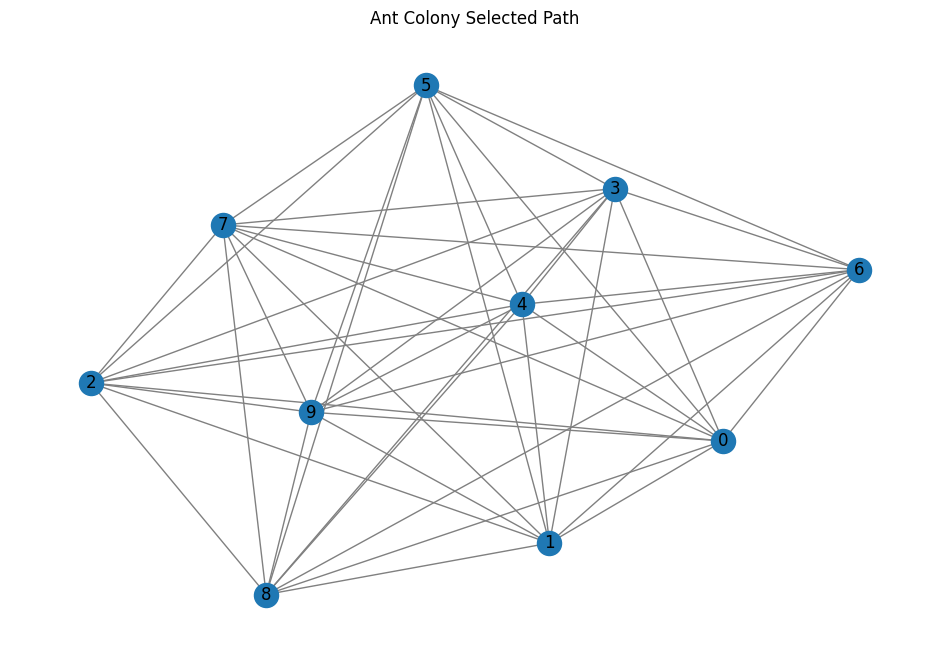

In [184]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph from the distance matrix
G = nx.from_numpy_array(distances)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes

# Draw all the nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Show plot
plt.title('Ant Colony Selected Path')
plt.axis('off')  # Hide axis
plt.show()

In [185]:
# Initialize the AntColony
antColony = AntColony(distances_array=distances, n_ants=10, n_best=5, n_iterations=100, decay=0.95, alpha=5, beta=1)

# Run the algorithm
shortest_path, cost = antColony.run()
shortest_path

([(0, 6),
  (6, 7),
  (7, 1),
  (1, 3),
  (3, 5),
  (5, 9),
  (9, 2),
  (2, 8),
  (8, 4),
  (4, 0)],
 127)

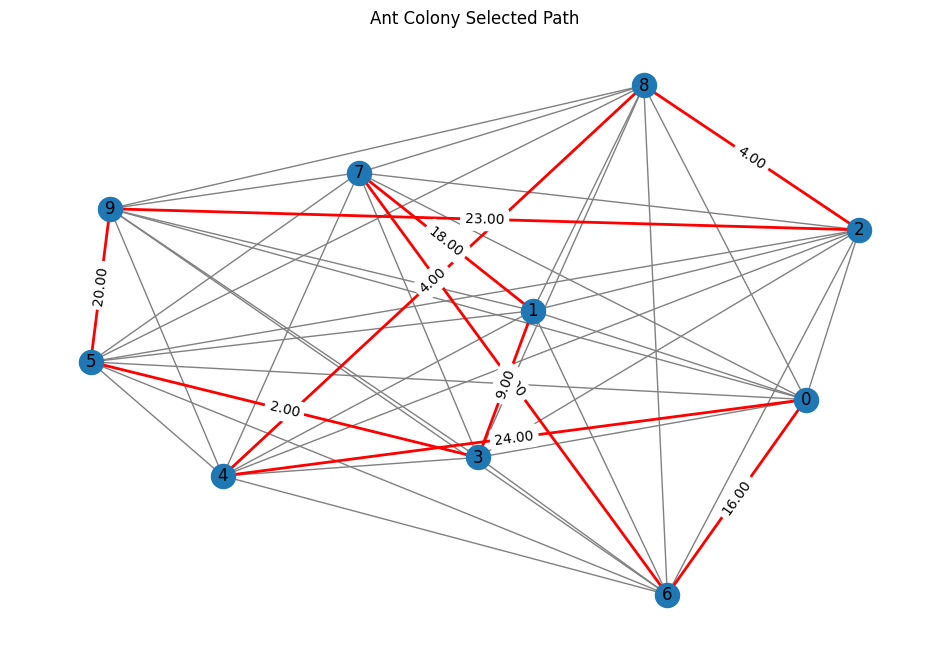

In [186]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph from the distance matrix
G = nx.from_numpy_array(distances)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes

# Draw all the nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Extract the path edges from the shortest path result
path_edges = [(shortest_path[0][i][0], shortest_path[0][i][1]) for i in range(len(shortest_path[0]))]

# Highlight the path of the ant colony
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f"{distances[i][j]:.2f}" for i, j in path_edges})

# Show plot
plt.title('Ant Colony Selected Path')
plt.axis('off')  # Hide axis
plt.show()

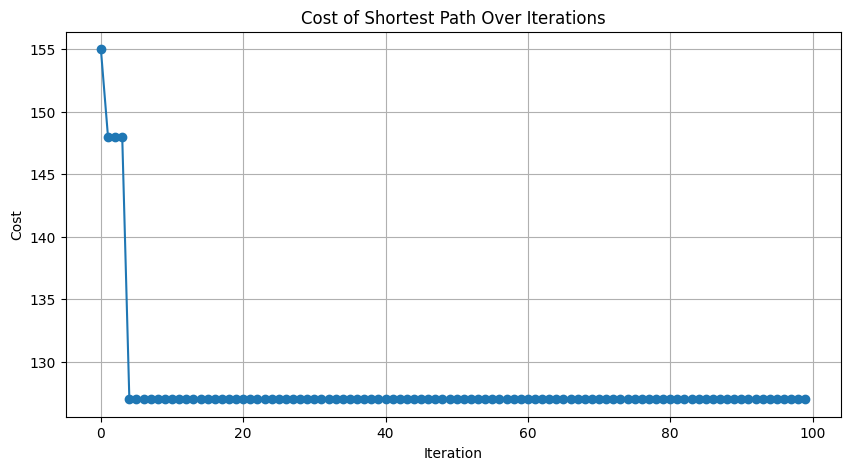

In [187]:
# Plot the costs
plt.figure(figsize=(10, 5))
plt.plot(cost, marker='o')
plt.title('Cost of Shortest Path Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.show()